## Tutorial of using flan-t5 with this library

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/align-transformers/blob/main/tutorials/basic_tutorials/Add_New_Model_Type.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This library only supports a set of library as a priori. We allow users to add new model architectures to do intervention-based alignment training, and static path patching analyses. This tutorial shows how to deal with new model type that is not pre-defined in this library.

**Note that this tutorial will not add this new model type to our codebase. Feel free to open a PR to do that!**

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [3]:
import sys
sys.path.append("../..")

import torch
import pandas as pd
from models.constants import CONST_OUTPUT_HOOK
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import Intervention, VanillaIntervention
from models.utils import lsm, sm, top_vals, format_token, type_to_module_mapping, type_to_dimension_mapping

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10

[2023-12-19 11:54:36,232] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### Try on new model type Flan_t5

In [4]:
def create_flan_t5(name="google/flan-t5-small", cache_dir="../../../.huggingface_cache"):
    """Creates a t5 model, config, and tokenizer from the given name and revision"""
    from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
    
    config = T5Config.from_pretrained(name)
    tokenizer = T5Tokenizer.from_pretrained(name)
    t5 = T5ForConditionalGeneration.from_pretrained(name, config=config, cache_dir=cache_dir)
    print("loaded model")
    return config, tokenizer, t5

def embed_to_distrib_t5(embed, log=False, logits=False):
    """Convert an embedding to a distribution over the vocabulary"""
    with torch.inference_mode():
        vocab = embed
        if logits:
            return vocab
        return lsm(vocab) if log else sm(vocab)

config, tokenizer, t5 = create_flan_t5()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


loaded model


In [5]:
base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt"),
    tokenizer(source, return_tensors="pt")
]
decoder_input_ids = tokenizer("", return_tensors="pt").input_ids
print(base)
res = t5(**inputs[0], decoder_input_ids=decoder_input_ids)
distrib = embed_to_distrib_t5(res.logits, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = t5(**inputs[1], decoder_input_ids=decoder_input_ids)
distrib = embed_to_distrib_t5(res.logits, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
Madrid               0.08071776479482651
                     0.05465298891067505
the                  0.05142271891236305
Spain                0.044039856642484665
El                   0.03095950372517109
Valencia             0.026710543781518936
capital              0.026438357308506966
La                   0.020008759573101997
The                  0.013906280510127544
Central              0.013829439878463745

The capital of Italy is
                     0.08179678022861481
the                  0.08141565322875977
Italy                0.05989212542772293
its                  0.039061129093170166
Milan                0.035837408155202866
Geno                 0.030690433457493782
Rome                 0.030660534277558327
capital              0.025854801759123802
Italian              0.023508301004767418
The                  0.020907413214445114


### To add t5, you only need the following block

In [6]:
"""Only define for the block output here for simplicity"""
type_to_module_mapping[type(t5)] = {
    "mlp_output": ("encoder.block[%s].layer[1]", CONST_OUTPUT_HOOK),
    "attention_input": ("encoder.block[%s].layer[0]", CONST_OUTPUT_HOOK),
}
type_to_dimension_mapping[type(t5)] = {
    "mlp_output": ("d_model", ),
    "attention_input": ("d_model", ),
    # the following fields are necessary for the module to run!
    "block_output": ("d_model", ),
    "head_attention_value_output": ("d_model/num_heads", ),
}

### Path patching with t5

In [7]:
def simple_position_config(model_type, intervention_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=VanillaIntervention,
    )
    return alignable_config
base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]
base["decoder_input_ids"] = decoder_input_ids
sources[0]["decoder_input_ids"] = decoder_input_ids

In [19]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode("Madrid Rome")[:2]

data = []
for layer_i in range(t5.config.num_layers):
    alignable_config = simple_position_config(type(t5), "mlp_output", layer_i)
    alignable = AlignableModel(alignable_config, t5)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_t5(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"f{layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    alignable_config = simple_position_config(type(t5), "attention_input", layer_i)
    alignable = AlignableModel(alignable_config, t5)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_t5(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

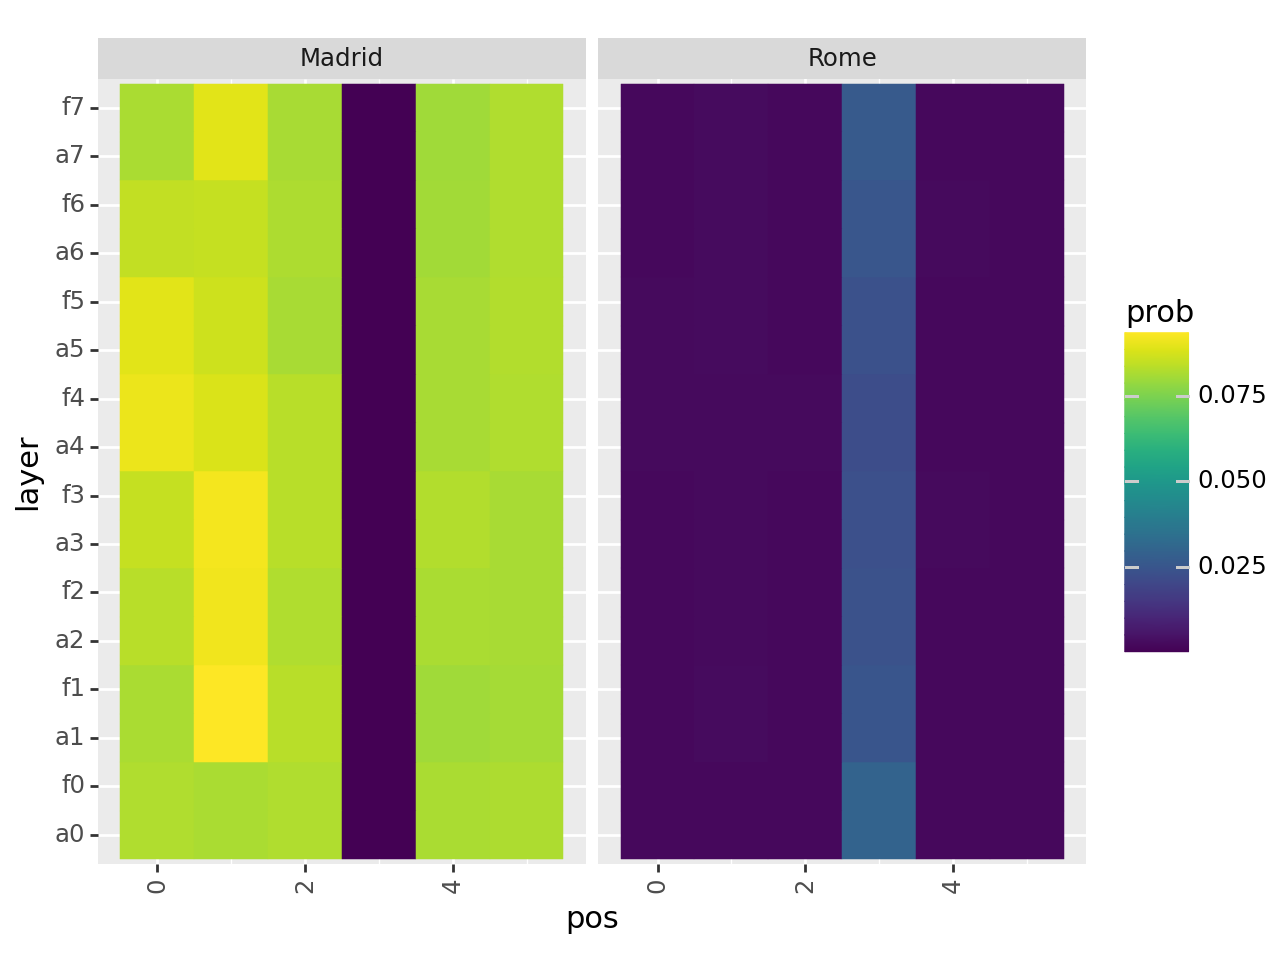

In [73]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(t5.config.num_layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

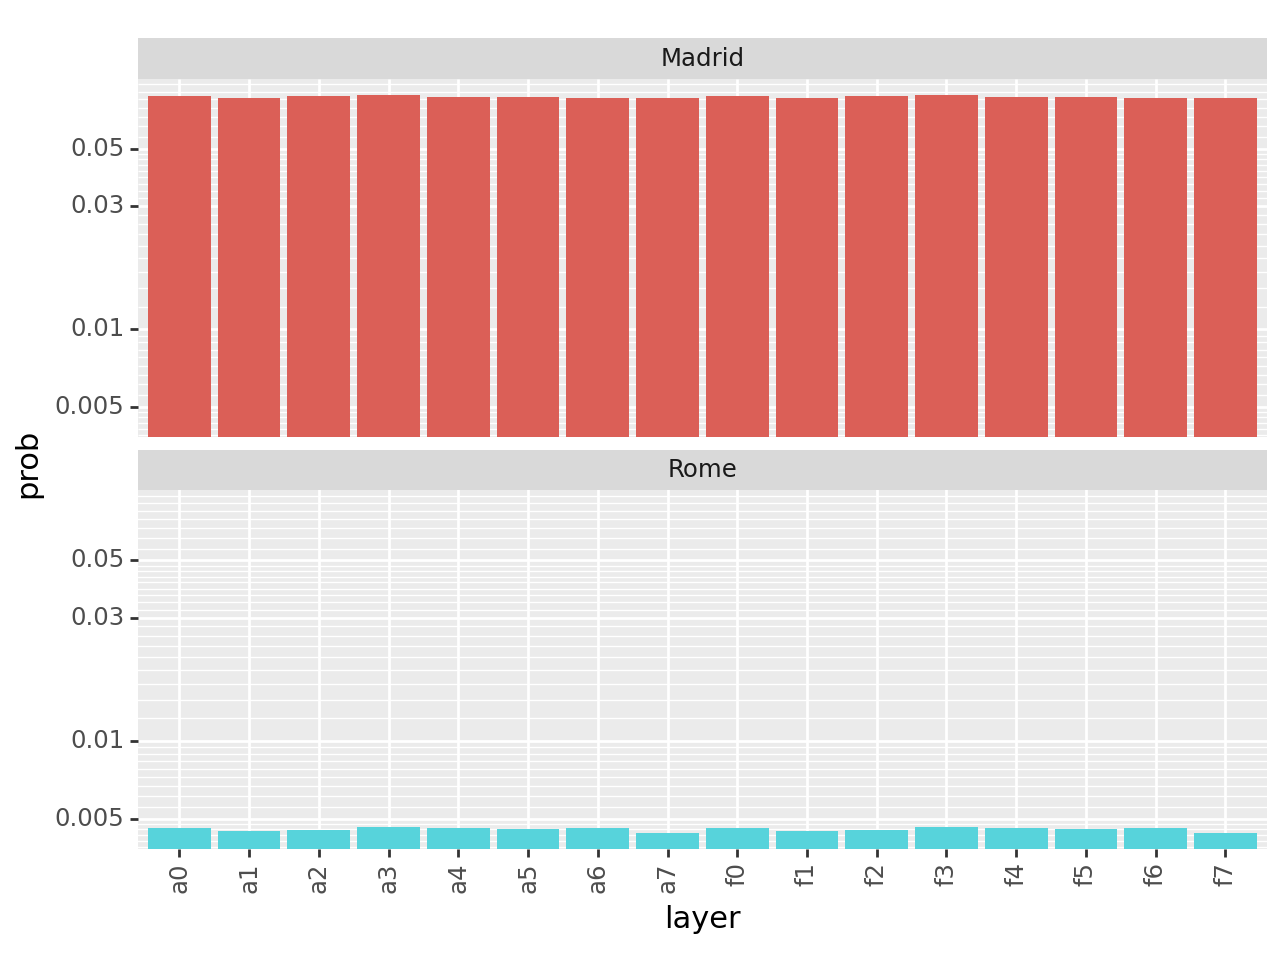

In [21]:
filtered = df
filtered = filtered[filtered['pos'] == 4]
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
print(g)

### Define a new additive intervention that adds a little bit of *Rome*

In [22]:
rome = t5.shared(torch.tensor(5308))
layer_norm = torch.nn.LayerNorm(rome.shape)

class AddingRomeIntervention(Intervention):
    
    """Intervention that is strange and destroys basis."""
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = None
        self.embed_dim = embed_dim

    def set_interchange_dim(self, interchange_dim):
        self.interchange_dim = interchange_dim

    def forward(self, base, source):
        # interchange
        base[:self.interchange_dim] += rome
        
        return layer_norm(base)

    def __str__(self):
        return f"AddingRomeIntervention(embed_dim={self.embed_dim})"
    
def simple_position_config(model_type, intervention_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=AddingRomeIntervention,
    )
    return alignable_config

In [23]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode("Madrid Rome")[:2]

data = []
for layer_i in range(t5.config.num_layers):
    alignable_config = simple_position_config(type(t5), "mlp_output", layer_i)
    alignable = AlignableModel(alignable_config, t5)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_t5(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"f{layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    alignable_config = simple_position_config(type(t5), "attention_input", layer_i)
    alignable = AlignableModel(alignable_config, t5)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_t5(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

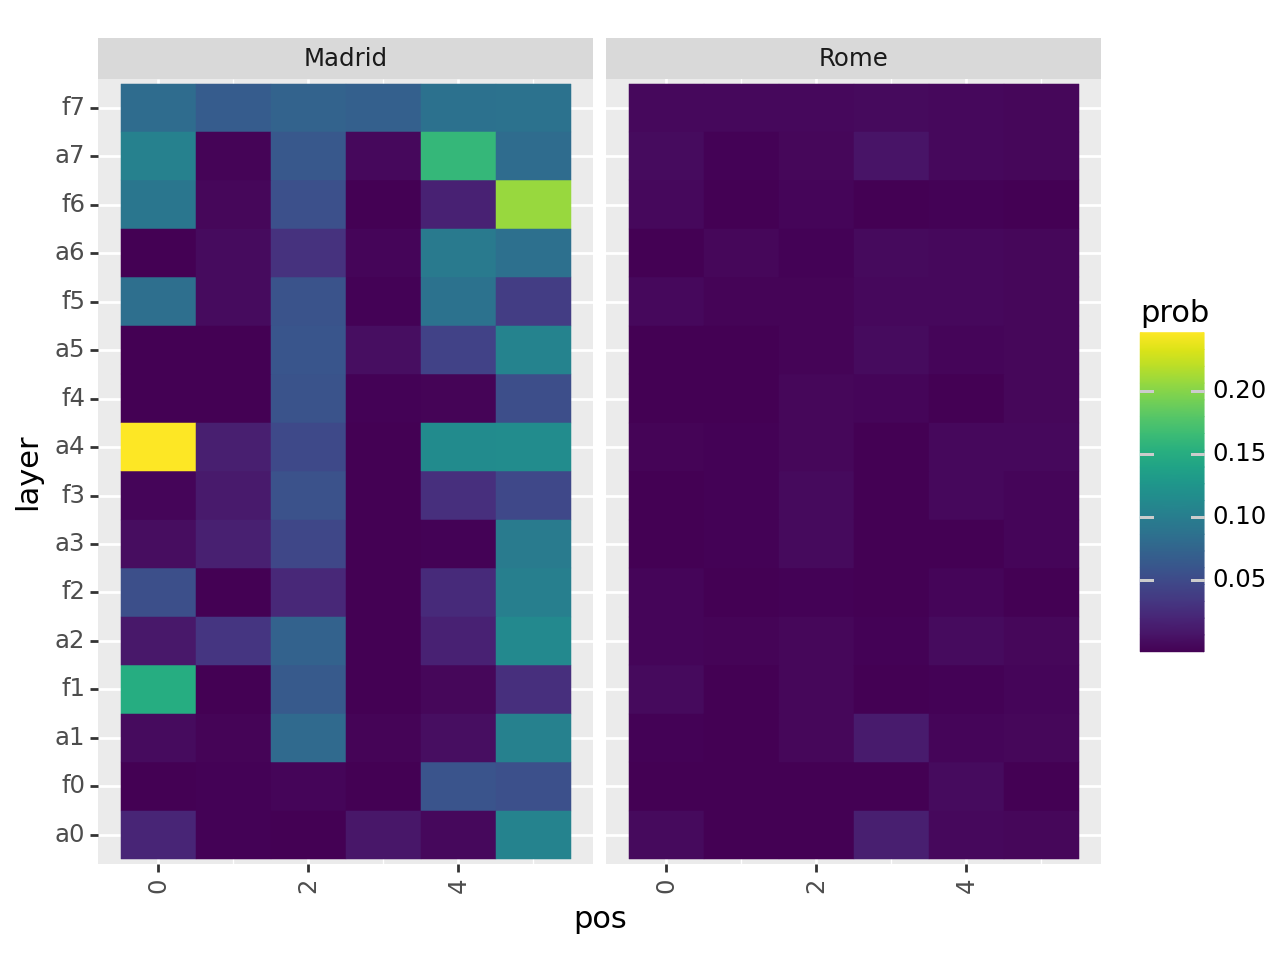

In [24]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(t5.config.num_layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

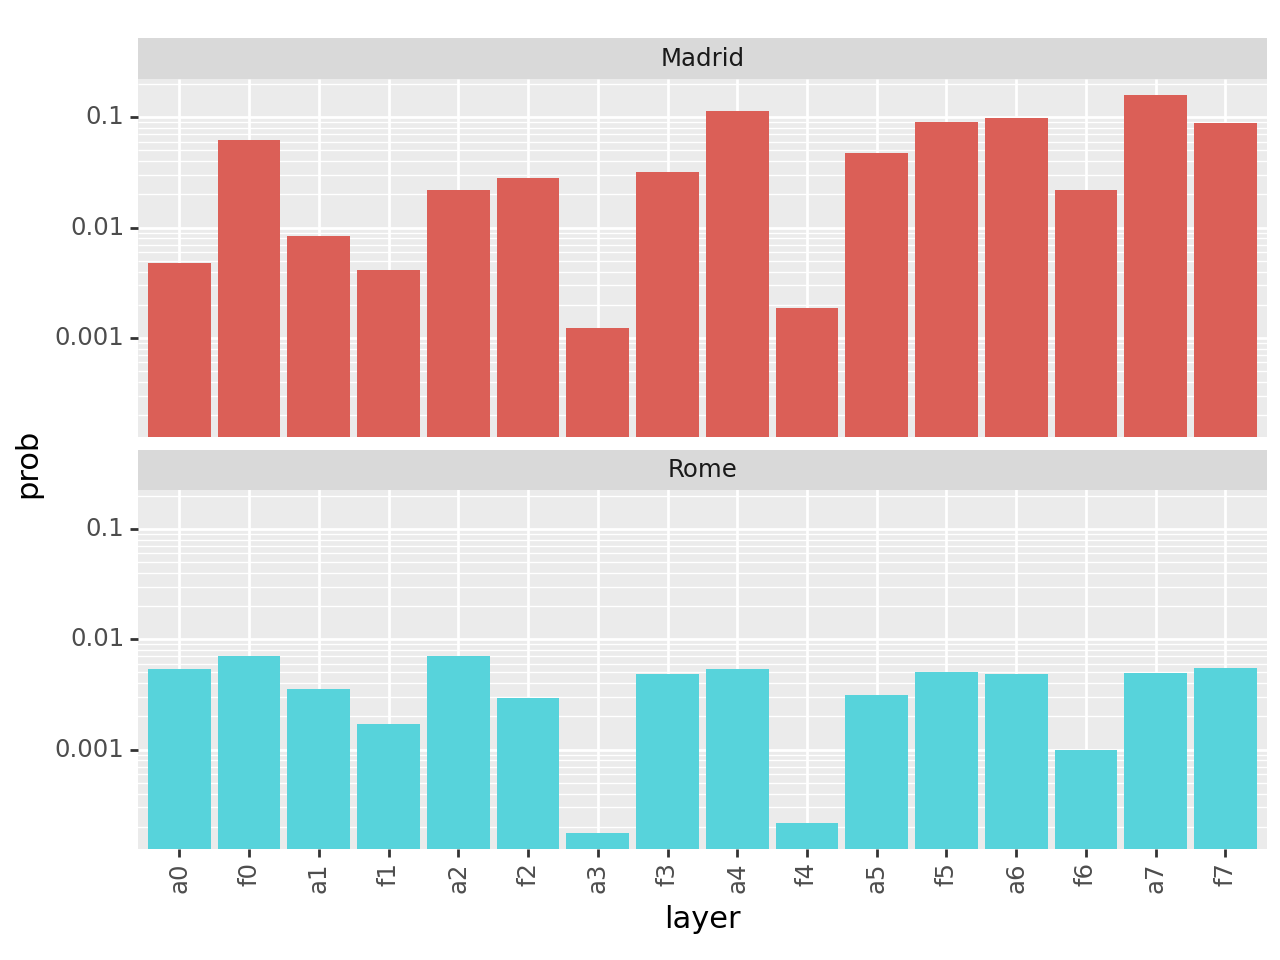

In [25]:
filtered = df
filtered = filtered[filtered['pos'] == 4]
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
print(g)